<a href="https://colab.research.google.com/github/yermaka-a/collab-exes/blob/pytorch_collab_exes/04_custom_dataset_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
## 0. Importing pytorch and setting up device-agnostic code
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. get data
our dataset is a subset of the Food101 dataset.
Food101 starts 101 different classes of food (750 training, 250 testing).
Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).
Why do this?
When starting out ML projects, it's important to try things on a small scale and then increasy the scale when necessary.
The whole point is to speed up how fast you can experiment.

In [81]:
from torch import nn
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:

  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [82]:
import os
def walk_through_dir(dir_path):
  """
    Walks through dir_path returning its contents
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [83]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [84]:
# setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 visualizing and image
let's write some code to:
1. get all of the image paths
2. pick a random image path using python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images let's open the image with python's PIL
5. We'll then show the image and print metadata


data/pizza_steak_sushi/train/steak/3577618.jpg
steak
Random image path data/pizza_steak_sushi/train/steak/3577618.jpg
Image class: steak
Image height: 512
Image width: 512


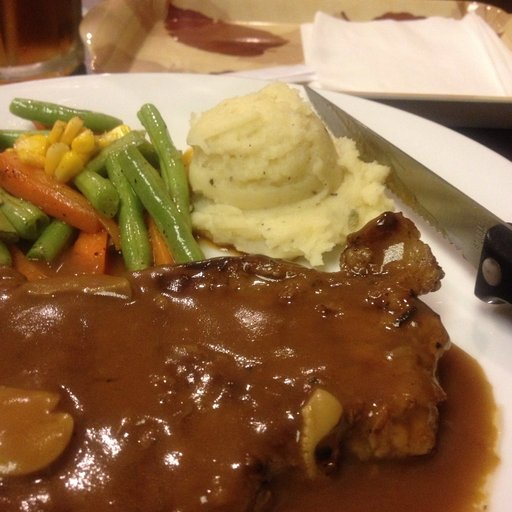

In [85]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

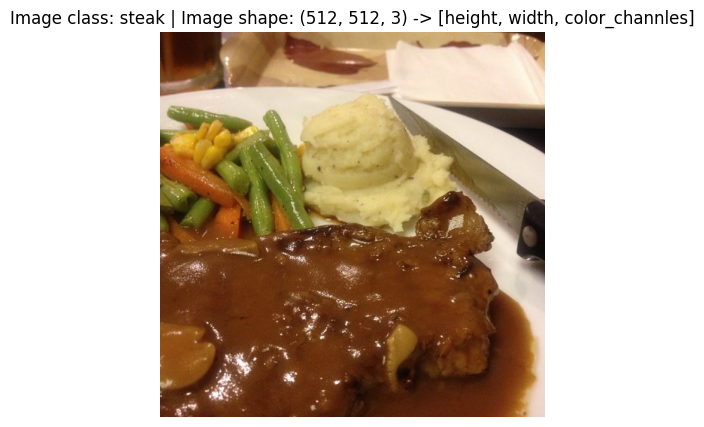

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_as_array = np.asarray(img)
# Plot the image with matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channles]")
plt.axis(False)

## 3. transforming data
Before we can use our image data with PyTorch
1. turn your target data into tensors (in our case, numerical representation of our images).
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` we'll call these `Dataset` and `DataLoader`

In [87]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 transforming data with `torchvision.transforms`
Transforms help you get your images ready to be used with a model/perform data augmenation: https://docs.pytorch.org/vision/main/transforms.html

In [88]:
from typing_extensions import dataclass_transform
# write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [89]:
data_transform(img).shape

torch.Size([3, 64, 64])

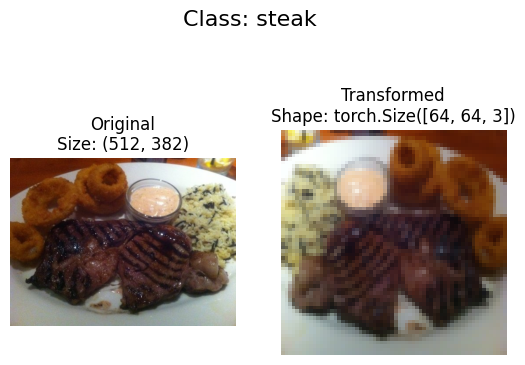

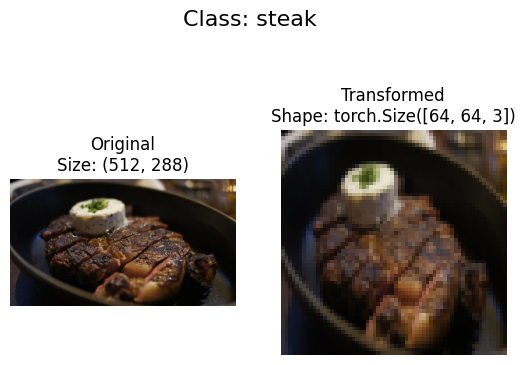

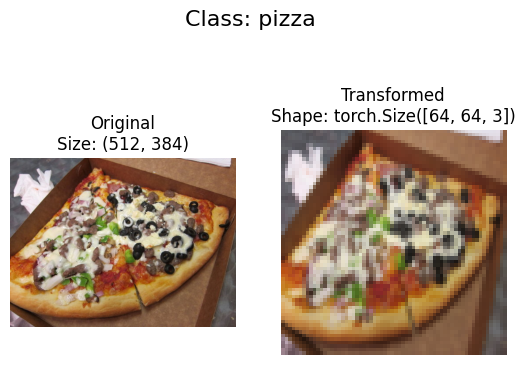

In [90]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs the transformed version.
  """

  if seed:
    random.seed(seed)
  reandom_image_paths = random.sample(image_paths, k=n)
  for image_path in reandom_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n=3,
    seed=None
    )

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.ImageFolder` -
https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [91]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder
train_data = ImageFolder(
    root=train_dir,
    transform=data_transform, # a transform for the data
    target_transform=None # a transform for the label/target
)

test_data = ImageFolder(
    root=test_dir,
    transform=data_transform,
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [92]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [93]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [94]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [95]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [96]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape:\n{img.shape}")
print(f"Image label:\n{label}")
print(f"Label datatype:\n{type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

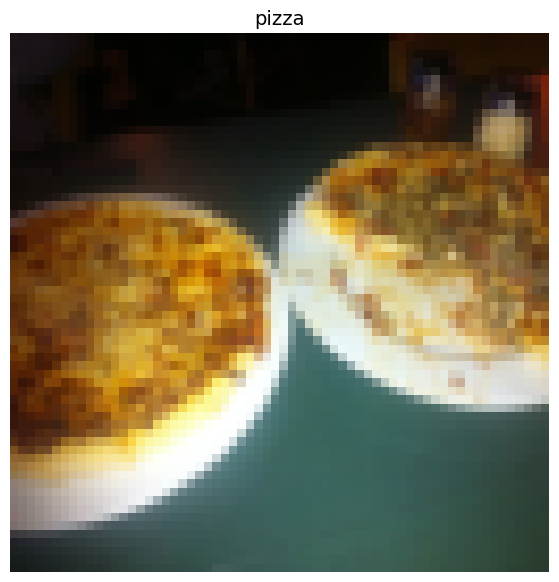

In [97]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)


### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so out model can see `batch_size` images at a time

In [98]:
import os
os.cpu_count()

2

In [99]:
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE=64
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=True
    )
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ce00c9091f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ce00c9aa300>)

In [100]:
len(train_dataloader), len(test_dataloader)

(4, 2)

In [101]:
len(train_data), len(test_data)

(225, 75)

In [102]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


## 5. Option 2: loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. Wnat to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or perfomance issues
All custom datasets in PyTorch often subclass - https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [103]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [104]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in stadartd image classification format)
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [105]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [106]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'pizza'>, <DirEntry 'sushi'>]

In [107]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Find the class folder names in a target directory.
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than string as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [108]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to interger labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [109]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, targ_dir: str, transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """
    Opens an image via a path and returns it.
    """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """Return the total number of samples."""
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data, data and label (X, y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [110]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [111]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform=train_transforms,
    )
test_data_custom = ImageFolderCustom(
    targ_dir=test_dir,
    transform=test_transforms,
)

In [112]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ce00c5c3560>,
 <__main__.ImageFolderCustom at 0x7ce00cf3d070>)

In [113]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [114]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the randomm seed for reproducibility
4. Get a list of random saple indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop throught the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images lone up with matpltloib (HWC)

In [115]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]= None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larget than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  reandom_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop throught random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(reandom_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channles, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

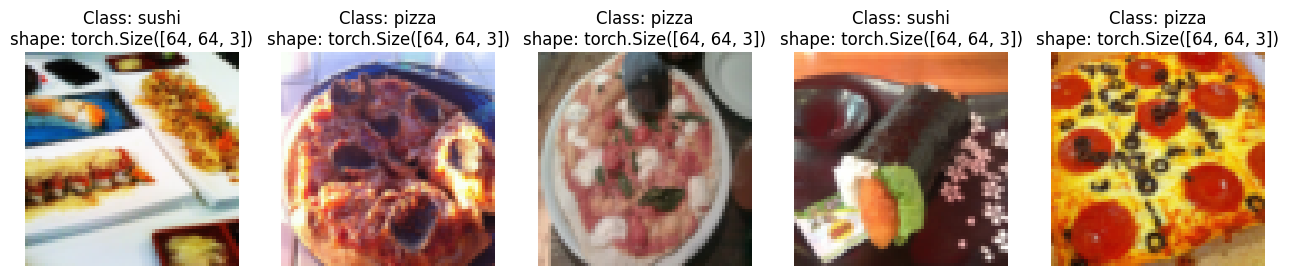

In [116]:
# Dsiplay random images from the ImageFolder created Dataset
display_random_images(
    train_data,
    n=5,
    classes=class_names,
    seed=42)

For display, purposes, n shouldn't be larget than 10, setting to 10 and removing shape display.


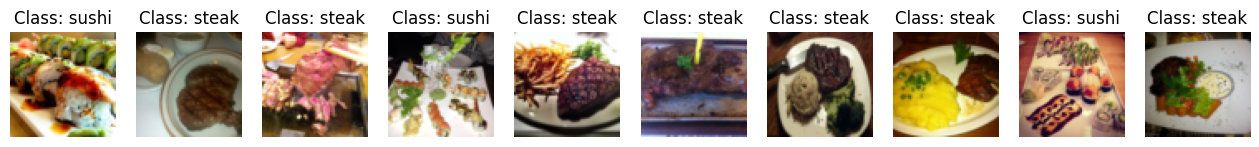

In [117]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(
    dataset=train_data_custom,
    n=20,
    classes=class_names,
    seed=42
)

### 5.4 Turn custom loaded images into `DataLoader`


In [118]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ce0376eb1a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ce00c78da60>)

In [119]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [120]:
# Let's look at trvialAugmentWide - https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#trivialaugmentwide
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [121]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

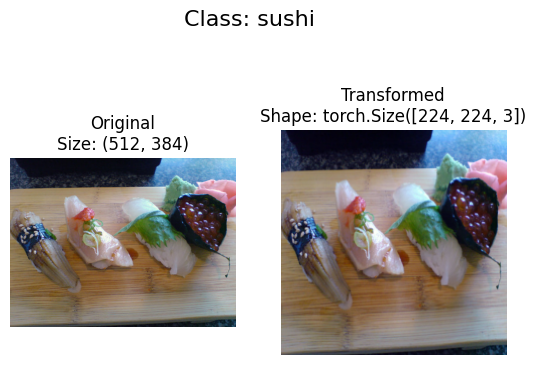

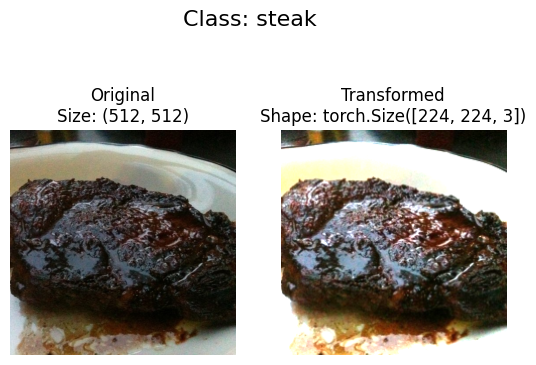

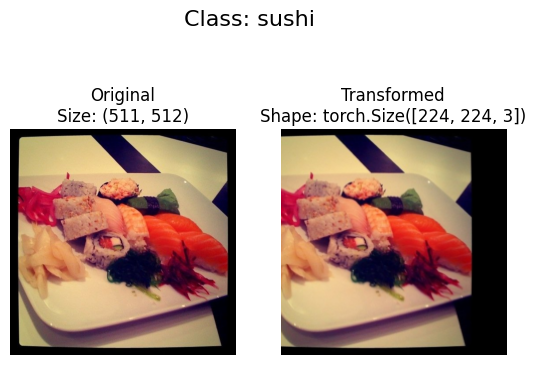

In [122]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

In [123]:
### 7.1 Creating transforms and loading data for Model 0

In [124]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [125]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

In [126]:
# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader
# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [127]:
# Create TinyVGG model class
class TinyVGGModelV1(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=in_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2
        )
    )
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2
        )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units * 13 * 13,
            out_features=out_shape
        )
    )
  def forward(self, x):
    # x = self.conv_layer_1(x)
    # x = self.conv_layer_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    return self.classifier(self.conv_layer_2(self.conv_layer_1(x))) # benefits from opeartor fusion: https://horace.io/brrr_intro.html

In [128]:
model_1 = TinyVGGModelV1(in_shape=3, hidden_units=10, out_shape=len(class_names)).to(device)
rand_t = torch.randn(size=(3, 64, 64)).to(device)
model_1(rand_t.unsqueeze(0))

tensor([[ 0.0010, -0.0087,  0.0027]], grad_fn=<AddmmBackward0>)

### 7.3 Try a forward pass on a singel image (to test the model)

In [129]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [130]:
# Try a forward pass
model_1(image_batch.to(device)).shape

torch.Size([32, 3])

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [131]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_1, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGModelV1                           [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [132]:
## 7.5 Create train and test loops functions
from torch.optim import Optimizer
def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: Optimizer,
    device = device
):
  train_acc, train_loss = 0, 0
  model = model.to(device)
  model.train()
  for _, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = y_pred.softmax(dim=1).argmax(dim=1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)
  train_acc = train_acc / len(dataloader)
  train_loss = train_loss / len(dataloader)
  return train_loss, train_acc
def test_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    device = device
):
  test_acc, test_loss = 0, 0
  model.eval()
  with torch.inference_mode():
    for _, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred_logits = model(X)
      loss = loss_fn(y_pred_logits, y)
      test_pred_labels = y_pred_logits.argmax(dim=1)
      test_loss += loss.item()
      test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)
  test_acc = test_acc / len(dataloader)
  test_loss = test_loss / len(dataloader)
  return test_loss, test_acc


In [133]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

In [134]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer
def train(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: Optimizer,
    loss_fn: nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device=device
):
# 2. Create empty results dictionary
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
#. 3 Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model=model_1,
        dataloader=train_dataloader_simple,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )

    test_loss, test_acc = test_step(
        model=model_1,
        dataloader=test_dataloader_simple,
        loss_fn=loss_fn,
        device=device
    )
    print(f" Epoch: {epoch} | Train loss: {train_loss} | Train acc: {train_acc} | Test loss: {test_loss} | Test acc: {test_acc}")

  # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [135]:
from timeit import default_timer as timer
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start = timer()
model_1_results = train(
    model=model_1,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5
)
end = timer()
print(f"Total training time: {end - start:3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch: 0 | Train loss: 1.104713812470436 | Train acc: 0.25 | Test loss: 1.0963801209131876 | Test acc: 0.37333333333333335
 Epoch: 1 | Train loss: 1.0881912410259247 | Train acc: 0.43359375 | Test loss: 1.0989619906743366 | Test acc: 0.3333333333333333
 Epoch: 2 | Train loss: 1.0809156224131584 | Train acc: 0.42578125 | Test loss: 1.1076908930142721 | Test acc: 0.3333333333333333
 Epoch: 3 | Train loss: 1.1136743277311325 | Train acc: 0.3046875 | Test loss: 1.1098274834950765 | Test acc: 0.3333333333333333
 Epoch: 4 | Train loss: 1.0820729434490204 | Train acc: 0.42578125 | Test loss: 1.1021474377314249 | Test acc: 0.3333333333333333
Total training time: 5.671716 seconds


### 7.8 Plot the loss curve s of Model 1
A **loss curve** is a way of tracking your model
s progress over time.

In [136]:
# Get the model_0_results keys
model_1_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [137]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary"""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

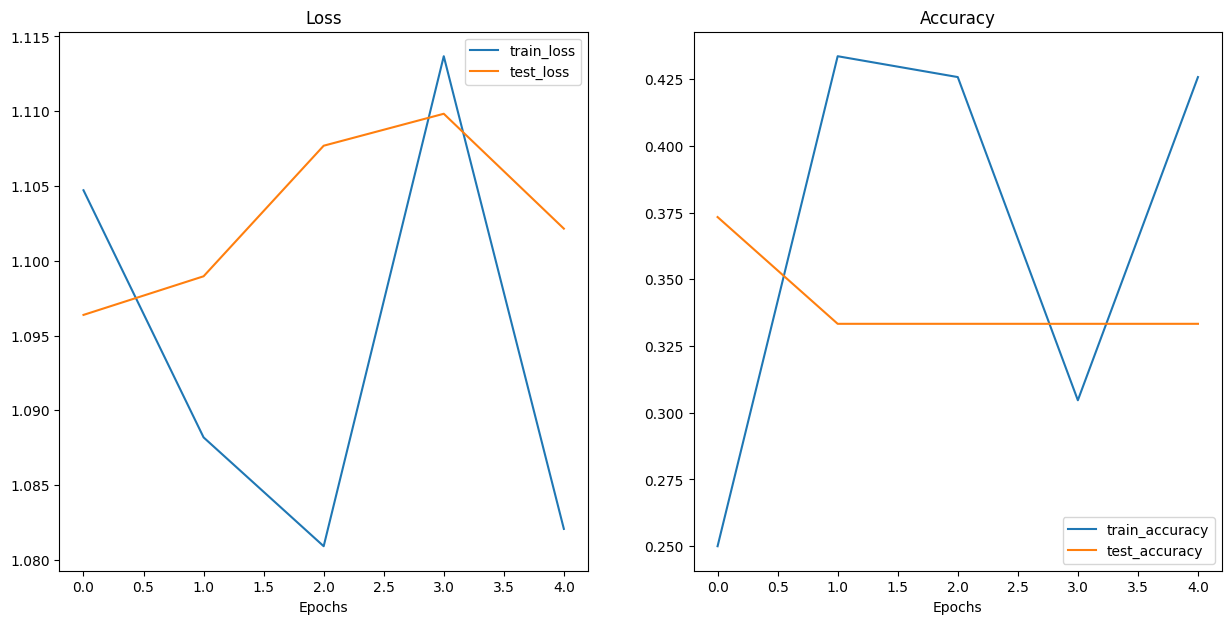

In [138]:
plot_loss_curves(model_1_results)

## 8. What should an ideal loss curve look like?
https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves?hl=ru

A loss curve is one of the most helpful ways to troubleshoot a model

## 9. Model 1: TinyVGG with Data Augmentation
Now let's try another modelling experiment this time using the same model as before with some slight data augmentation.

### 9.1 Create transform with data augmentation

In [139]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transfrom_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [140]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial
    )
test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=test_transfrom_simple
)

In [141]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
    )

### 9.3 Contruct and train model 1
This time we'll be using the same model architecture except this time we've augmented the training data.

In [142]:
# Create model_2 and send it to the target device
torch.manual_seed(42)
model_2 = TinyVGGModelV1(
    in_shape=3,
    hidden_units=10,
    out_shape=len(train_data_augmented.classes)
)
model_2

TinyVGGModelV1(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon our `train()` function to train and evaluate our model.

In [143]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start = timer()
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end = timer()
print(f"Total training time for model_2: {end-start:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch: 0 | Train loss: 1.0817953497171402 | Train acc: 0.42578125 | Test loss: 1.1222112973531086 | Test acc: 0.2604166666666667
 Epoch: 1 | Train loss: 1.0758972764015198 | Train acc: 0.42578125 | Test loss: 1.1222112973531086 | Test acc: 0.2604166666666667
 Epoch: 2 | Train loss: 1.079109825193882 | Train acc: 0.42578125 | Test loss: 1.1222112973531086 | Test acc: 0.2604166666666667
 Epoch: 3 | Train loss: 1.0952438116073608 | Train acc: 0.3046875 | Test loss: 1.1222112973531086 | Test acc: 0.2604166666666667
 Epoch: 4 | Train loss: 1.0767937675118446 | Train acc: 0.42578125 | Test loss: 1.1222112973531086 | Test acc: 0.2604166666666667
Total training time for model_2: 5.886 seconds


In [144]:
model_2_results

{'train_loss': [1.0817953497171402,
  1.0758972764015198,
  1.079109825193882,
  1.0952438116073608,
  1.0767937675118446],
 'train_acc': [0.42578125, 0.42578125, 0.42578125, 0.3046875, 0.42578125],
 'test_loss': [1.1222112973531086,
  1.1222112973531086,
  1.1222112973531086,
  1.1222112973531086,
  1.1222112973531086],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667]}

### 9.4 plot the loss curves of model 2
A loss curve helps you evaluate your models perfomance overtime.

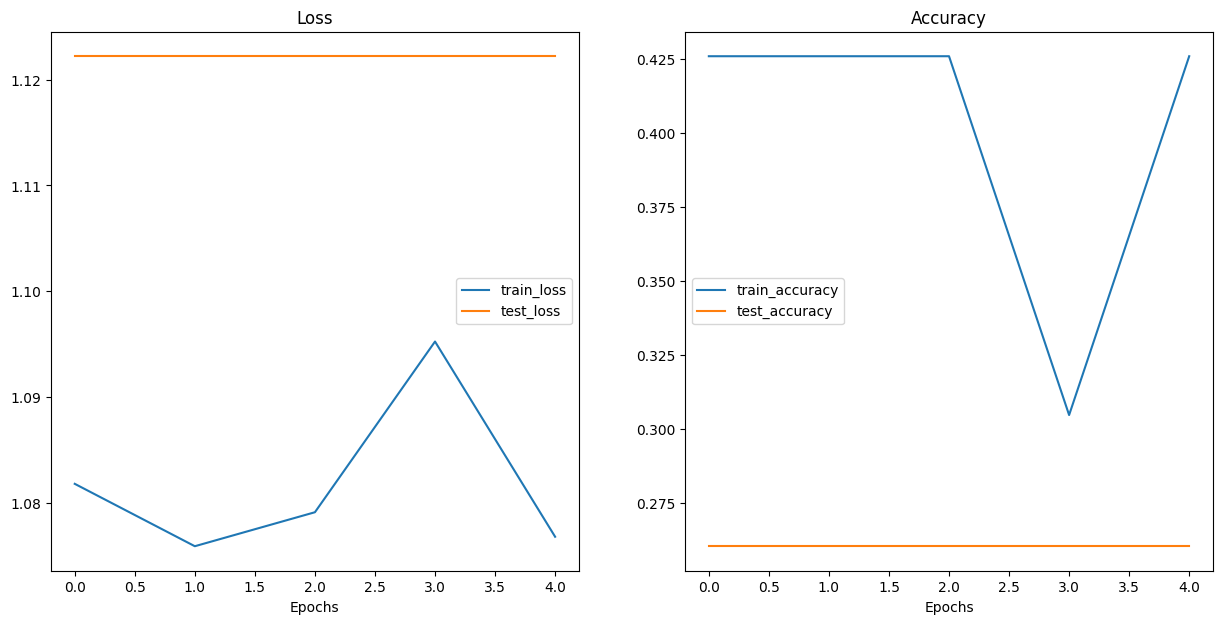

In [145]:
plot_loss_curves(model_2_results)

# 10. Compare model results
After evaluating our modelling experiments on their own, it's important to compare them to each other.

Ther's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://docs.pytorch.org/docs/stable//tensorboard.html
3. wieghts & biases - https://wandb.ai/site/
4. MLFlow - https://mlflow.org/

In [146]:
import pandas as pd
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)

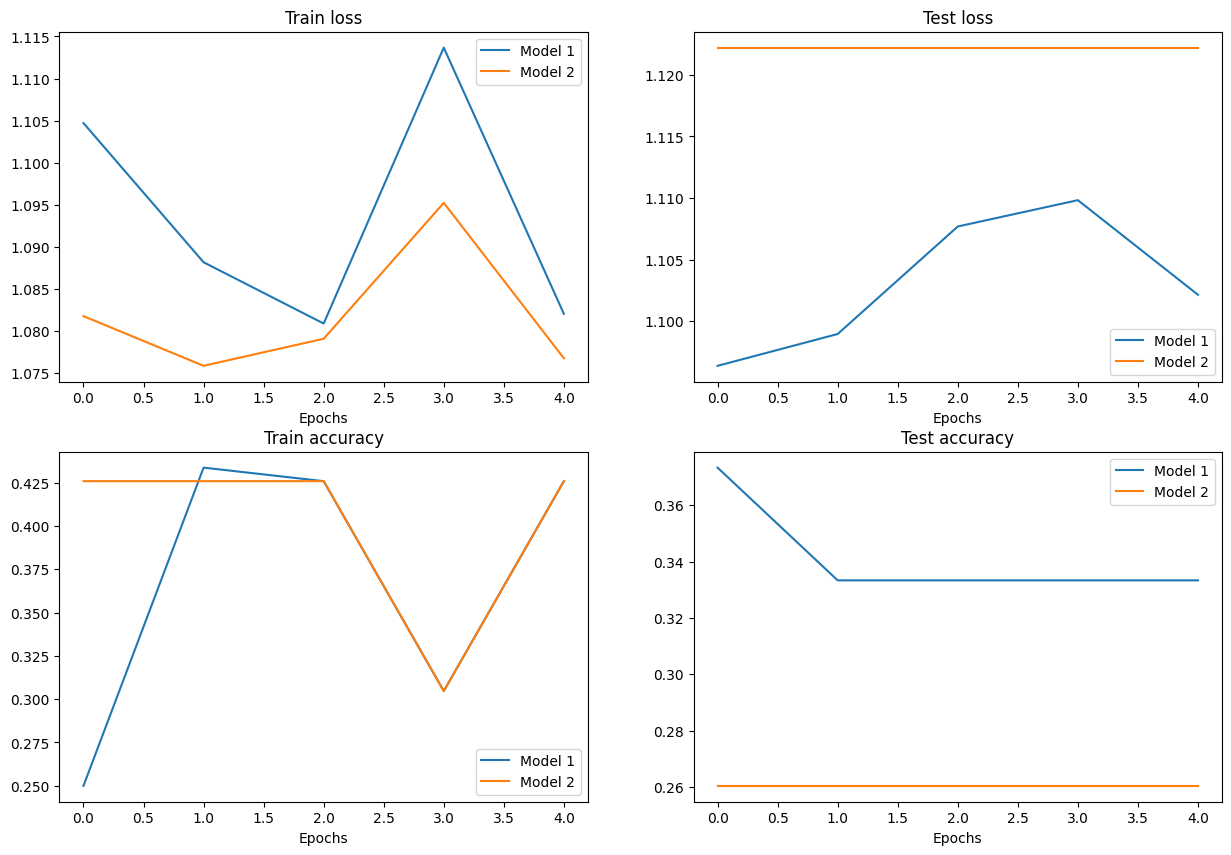

In [150]:
# setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.plot(epochs, model_2_df["train_loss"], label="Model 2")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.plot(epochs, model_2_df["test_loss"], label="Model 2")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.plot(epochs, model_2_df["train_acc"], label="Model 2")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.plot(epochs, model_2_df["test_acc"], label="Model 2")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image
Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset

In [151]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # when downloading from Github. need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists... skipping downloading")

### 11.1 loading in a custom image with pytorch

we have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* of hsape 64x64x3
* on the right device

In [156]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
custom_image_uint8.shape, custom_image_uint8.dtype

(torch.Size([3, 4032, 3024]), torch.uint8)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

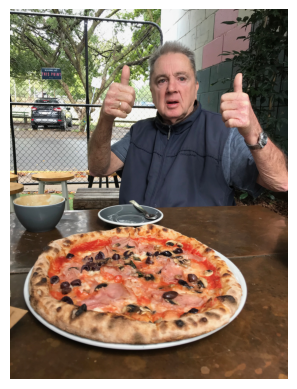

In [155]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.axis(False)

In [157]:
model_2.eval()
with torch.inference_mode():
  model_2(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [161]:
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32)


In [162]:
resize = transforms.Resize(size=(64, 64))
custom_img_resize = resize(custom_image)

In [168]:
model_2.eval()
with torch.inference_mode():
  pred_y = model_2(custom_img_resize.unsqueeze(0).to(device))
  label = pred_y.softmax(1).argmax(1).item()
class_names[label]

'pizza'